In [1]:
import torch
import pickle

from torchvision import transforms

# %matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("..") # Adds higher directory to python modules path.
from dynamic_bVAE.models import dynamicVAE32, beta_from_normalized_beta, build_tridiag
from data.dspritesbT import dSpriteBackgroundDatasetTime

mu:0,D:0,B:0
z:0,covariance_mats:0,precision_mats:0


In [2]:
normalized_beta_values = np.logspace(np.log(.001), np.log(5), 6, base=np.e)

N = 1 * 32 * 32
M = 10

beta = beta_from_normalized_beta(normalized_beta_values, N = N, M = M)


for ii,nb in enumerate(normalized_beta_values):
    print(['betanorm = %0.3f / beta = %0.1f' % (normalized_beta_values[ii],beta[ii])])

['betanorm = 0.001 / beta = 0.1']
['betanorm = 0.005 / beta = 0.6']
['betanorm = 0.030 / beta = 3.1']
['betanorm = 0.166 / beta = 17.0']
['betanorm = 0.910 / beta = 93.2']
['betanorm = 5.000 / beta = 512.0']


In [3]:
vae = list()
training_stats = list()
for ii,beta_norm in enumerate(normalized_beta_values):

    # beta values in the file name of checkpoints have varying number of decimal points (not so smart)
    beta_norm_str = '%0.4f' % (beta_norm)
    while beta_norm_str[-1] == '0' and beta_norm_str[-2] != '.':
        beta_norm_str = beta_norm_str[:-1]
    
    trainedpath = 'trained/dynamicvae32_nlatent=10_betanorm=%s_dspritesT_circle_last_500K' % (beta_norm_str)
    trainstatspath = 'trained/dynamicvae32_nlatent=10_betanorm=%s_dspritesT_circle_500K.pkl' % (beta_norm_str)
    
    vae.append(dynamicVAE32(n_latent = 10))
#     checkpoint = torch.load(trainedpath)
#     vae[ii].load_state_dict(checkpoint['model_states']['net'])
# 
#     training_stats.append(pickle.load(open(trainstatspath, 'rb')))

In [4]:
vae[0]

dynamicVAE32(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc_enc_mu): Linear(in_features=256, out_features=10, bias=True)
  (fc_enc_D): Linear(in_features=256, out_features=100, bias=True)
  (fc_enc_B): Linear(in_features=512, out_features=100, bias=True)
  (fc_dec): Linear(in_features=10, out_features=256, bias=True)
  (convT4): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (convT3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (convT2): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (convT1): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)

In [5]:

dt = dSpriteBackgroundDatasetTime(transform=transforms.Resize((32,32)),
                                   shapetype='circle',data_dir='data/dsprites-dataset/')

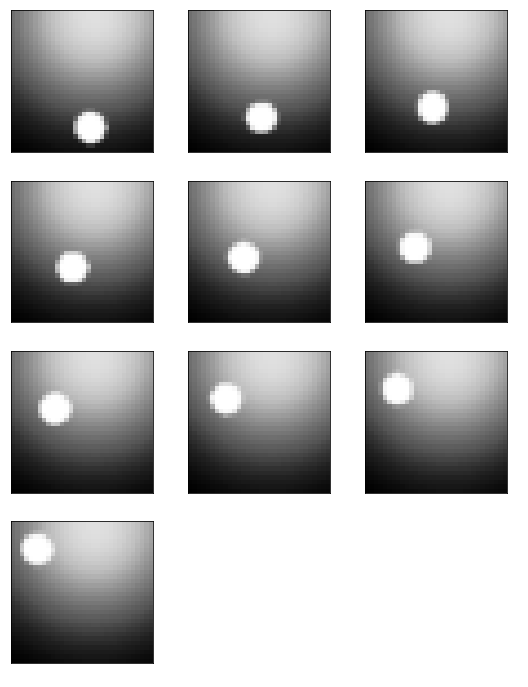

In [6]:
from data.dspritesb import show_images_grid
show_images_grid(dt[3][0])

In [7]:
dt[3][0].shape

torch.Size([10, 1, 32, 32])

In [8]:
vae[0].n_frames

10

In [9]:
x = dt[3][0]#.permute(1,2,3,0).unsqueeze(0)
x.shape
# vae[0].encode(dt[3][0])

torch.Size([10, 1, 32, 32])

torch.Size([25, 10, 1, 32, 32])


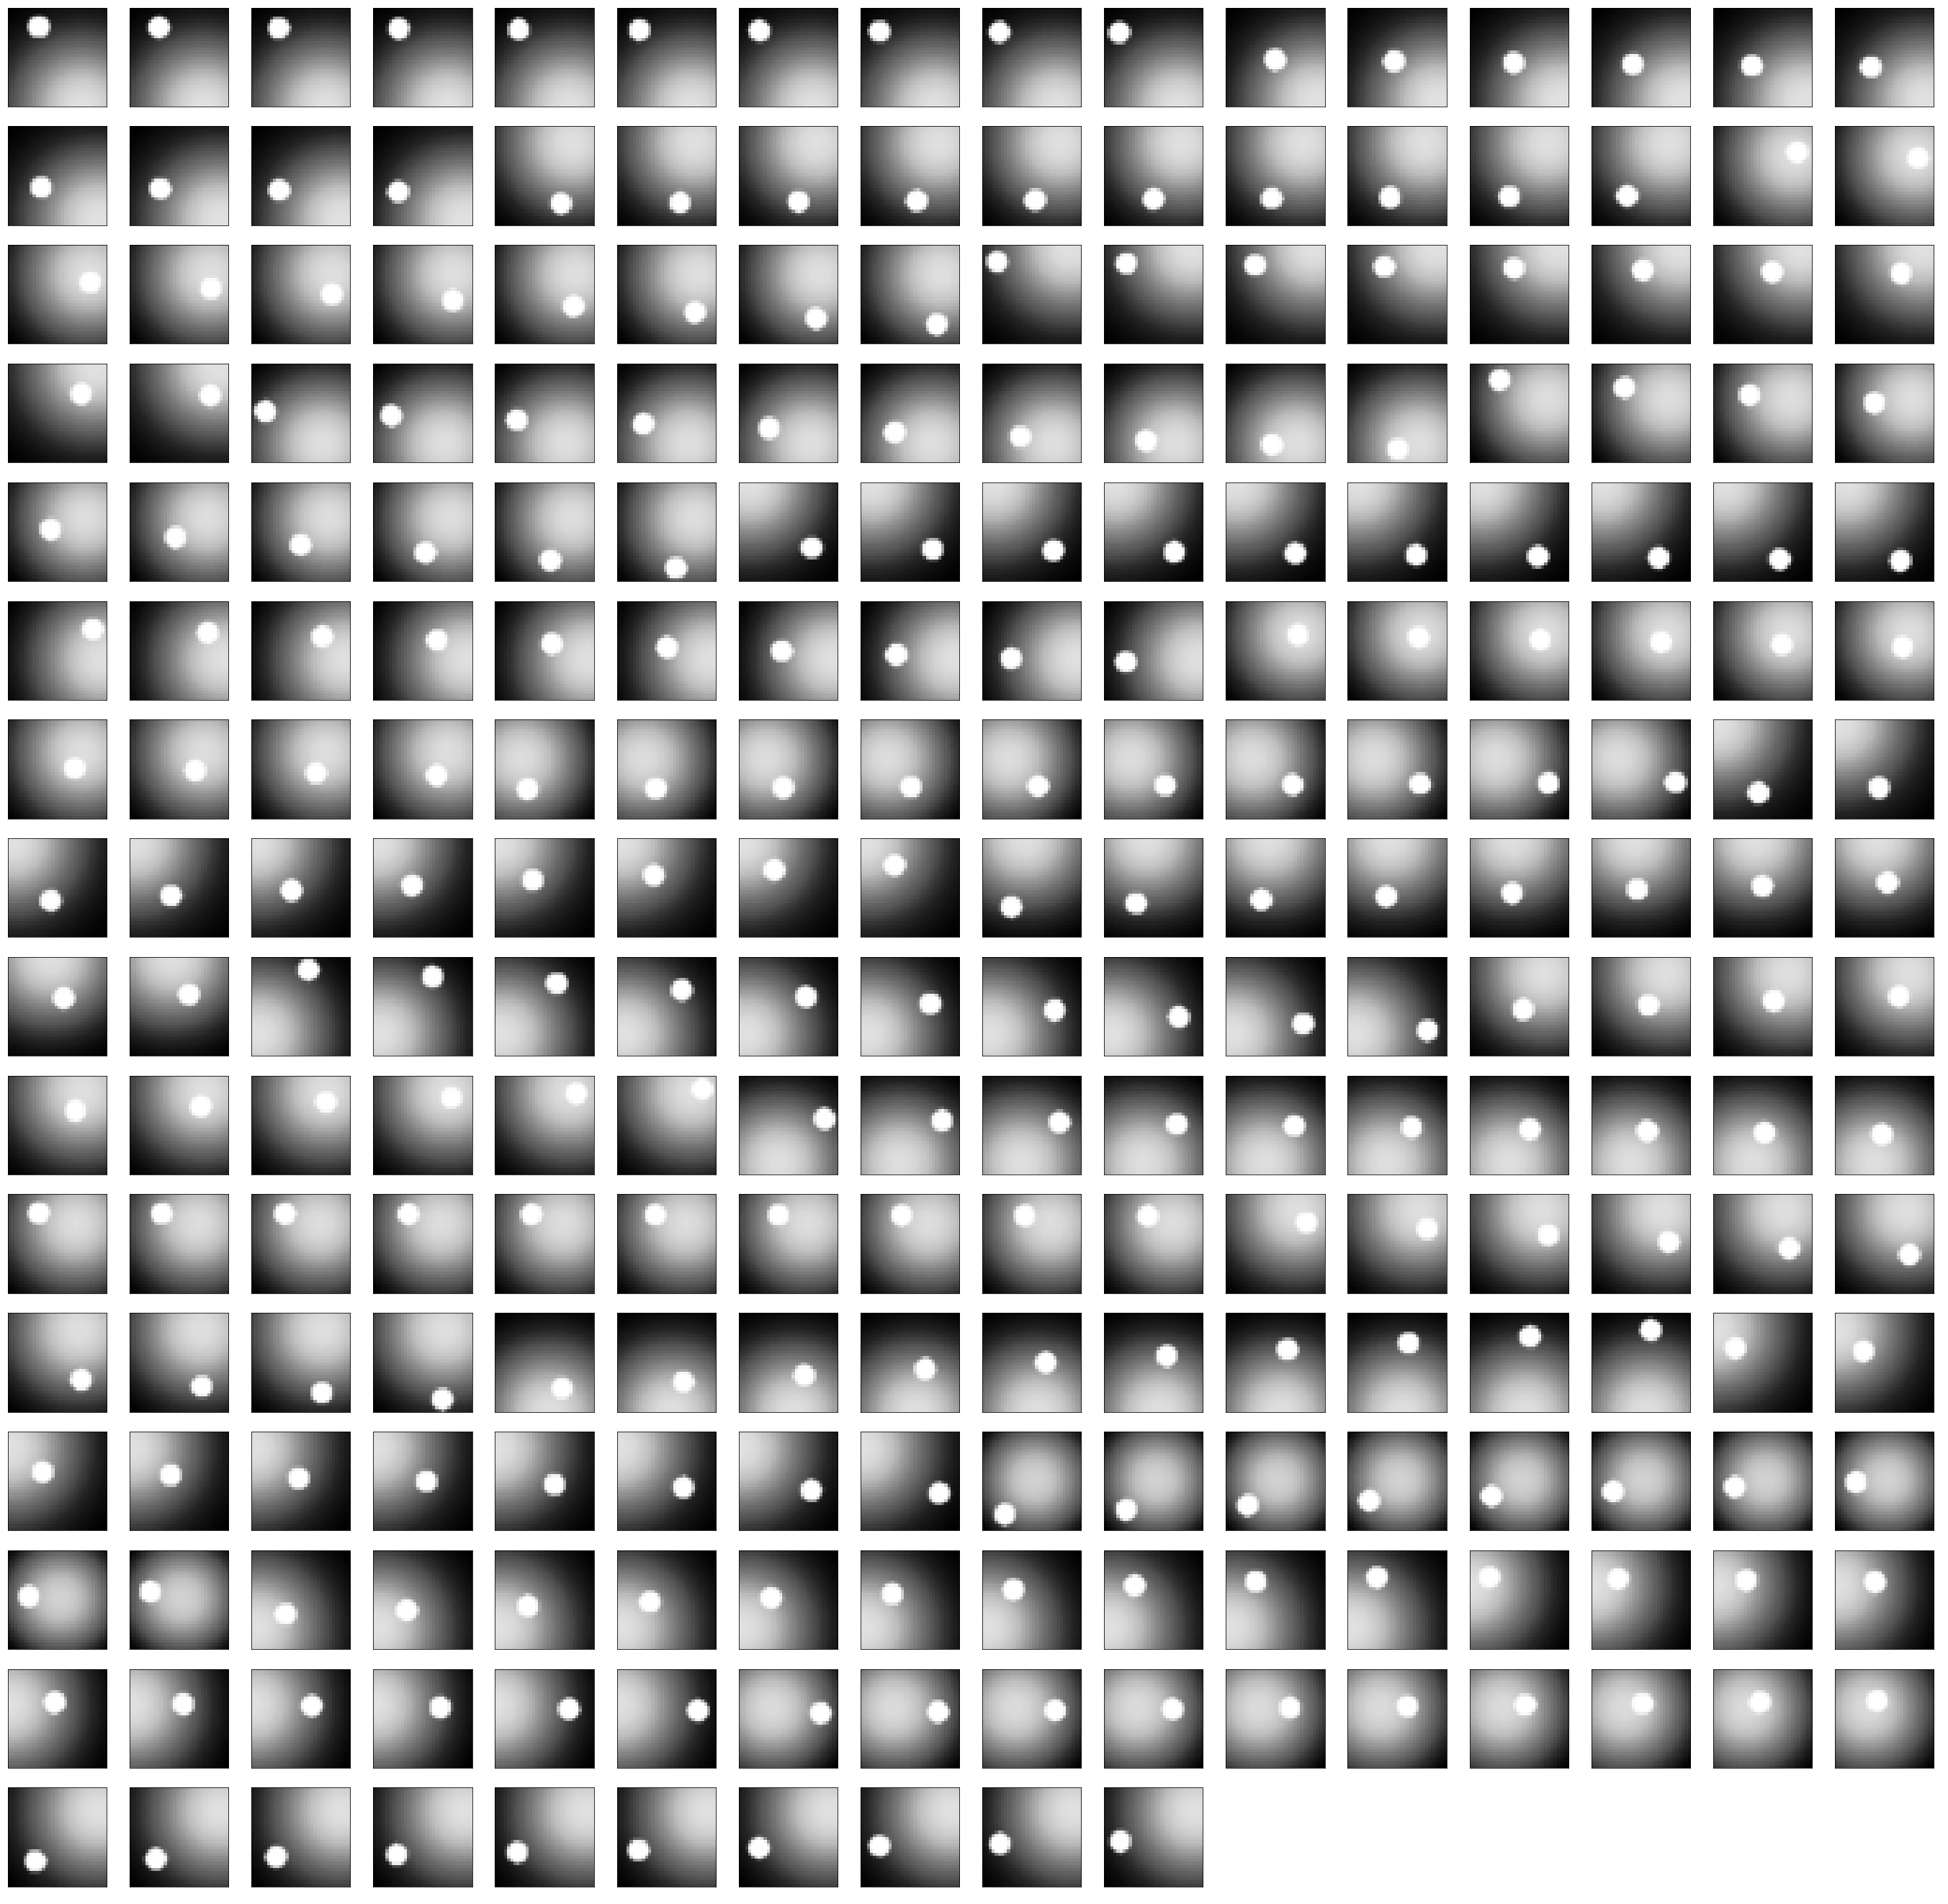

In [10]:
from torch.utils.data import Dataset, DataLoader
dataloader = DataLoader(dt, batch_size=25,shuffle=True, num_workers=4)
for i,[samples,latents] in enumerate(dataloader):
    print(samples.shape)
    show_images_grid(samples.view(25*10,1,32,32))
    break
x = samples

In [11]:
x.view(vae[0].n_frames*x.size(0),1,32,32).shape

torch.Size([250, 1, 32, 32])

In [12]:

x1=vae[0].conv1(x.view(vae[0].n_frames*x.size(0),1,32,32))
x1.shape
x4=vae[0].conv4(vae[0].conv3(vae[0].conv2(x1)))
x4.shape

torch.Size([250, 64, 2, 2])

In [13]:
x4.view(-1,256).shape

torch.Size([250, 256])

In [14]:
vae[0].fc_enc_mu(x4.view(-1,256)).shape

torch.Size([250, 10])

In [15]:
vae[0].fc_enc_D(x4.view(-1,256)).shape

torch.Size([250, 100])

In [16]:
vae[0].fc_enc_B(x4.view(-1,256*2)).shape

torch.Size([125, 100])

In [17]:
mu, D, B = vae[0].encode(x)

p = D.shape[1] - B.shape[1]
t = int(D.shape[1]/p)
mu.shape,p,t,int(p**0.5)

(torch.Size([25, 10, 10]), 1, 10, 1)

In [18]:
P = build_tridiag(D,B,alpha=0.5)
P.shape

torch.Size([25, 100, 100])

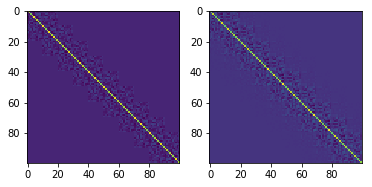

In [19]:
plt.subplot(1,2,1)
plt.imshow(P[0,:,:].detach().numpy())
plt.subplot(1,2,2)
plt.imshow(torch.inverse(P[0,:,:]).detach().numpy())

In [20]:
z, covariance_mats, precision_mats = vae[0].reparametrize(mu, D, B)#, alpha=0.5)
z.shape, covariance_mats.shape, precision_mats.shape

(torch.Size([25, 100]), torch.Size([25, 100, 100]), torch.Size([25, 100, 100]))

In [21]:
# eps = torch.randn_like(mu)
# z = torch.zeros_like(mu)
# for i in range(25):
# #     eps.shape,covariance_mat[i,:,:].shape,
#     z[i,:] = mu[i,:] + P[i,:,:].matmul(eps[i,:])
# # bigz = torch.t(covariance_mat.view(25*100,100).matmul(torch.t(eps).view(-1)).view(25,100,25).sum(0))

# plt.figure(figsize=(50,50))
# plt.imshow(torch.t(P.view(25*100,100)).detach())

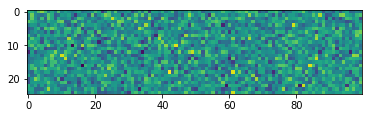

In [22]:
plt.imshow(z.detach())

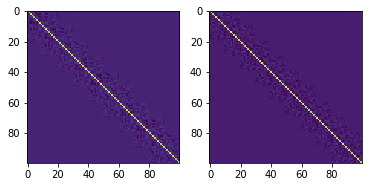

In [23]:
plt.subplot(1,2,1)
plt.imshow(covariance_mats[0,:,:].detach().numpy())
plt.subplot(1,2,2)
plt.imshow(precision_mats[0,:,:].detach().numpy())

In [24]:
x_recon = vae[0].decode(z)
x_recon.shape

torch.Size([25, 10, 1, 32, 32])

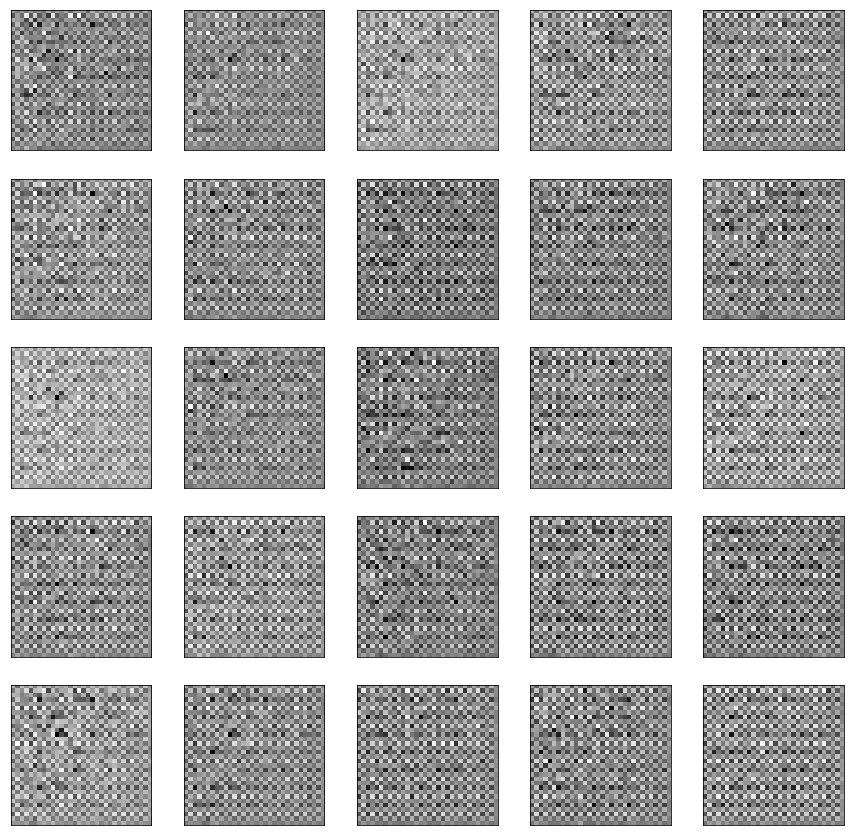

In [25]:
show_images_grid(x_recon.squeeze().detach())

In [26]:
from models import reconstruction_loss
recon_loss = reconstruction_loss(x, x_recon, distribution='gaussian')
recon_loss

mu:0,D:0,B:0
z:0,covariance_mats:0,precision_mats:0


tensor(569.7368, grad_fn=<DivBackward0>)

In [27]:
from models import kl_divergence
total_kld, dimension_wise_kld, mean_kld = kl_divergence(mu, covariance_mats, precision_mats)
total_kld, dimension_wise_kld, mean_kld

(tensor(5671.6562, grad_fn=<MeanBackward2>),
 tensor(226.8663, grad_fn=<MeanBackward2>),
 tensor(226.8663, grad_fn=<MeanBackward2>))

In [28]:
k = mu.size(0)
klds = 0.5*( torch.trace(covariance_mats[i,:,:]) + mu[i,:].view(-1).dot(mu[i,:].view(-1)) - k * torch.logdet(precision_mats[i,:,:]) )
klds

tensor(462.1149, grad_fn=<MulBackward0>)

In [29]:
batch_size=25
klds = torch.zeros(batch_size).to(precision_mats.device)
for b in range(batch_size):
    klds[b] = 0.5*( torch.trace(covariance_mats[b,:,:]) + mu[b,:].view(-1).dot(mu[b,:].view(-1)) - k * torch.logdet(precision_mats[b,:,:]) )
klds

tensor([462.1149, 461.4167, 460.2339, 460.5369, 461.4577, 460.0815, 459.9183,
        461.7809, 461.1587, 459.8454, 459.0824, 461.2370, 460.4503, 460.1667,
        460.3755, 459.8535, 458.9587, 460.4041, 460.3893, 461.4706, 459.0360,
        460.4454, 460.0801, 458.6198, 460.2003], grad_fn=<CopySlices>)

In [30]:
I = torch.sum(D)
I.backward()

In [31]:
# from main.py
from solver import Solver
import argparse

def str2bool(v):
    # codes from : https://stackoverflow.com/questions/15008758/parsing-boolean-values-with-argparse

    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

parser = argparse.ArgumentParser(description='dynamic beta VAE')

parser.add_argument('--model', default='dynamicVAE32', type=str, help='which model to train (dynamicVAE32, dynamicVAE64))')

parser.add_argument('--seed', default=1, type=int, help='random seed')
parser.add_argument('--cuda', default=True, type=str2bool, help='enable cuda')
parser.add_argument('--batch_size', default=64, type=int, help='batch size')
parser.add_argument('--shuffle', default=True, type=str2bool, help='shuffle training data')
parser.add_argument('--max_iter', default=500000, type=int, help='number of training iterations')

parser.add_argument('--lr', default=1e-4, type=float, help='learning rate')
parser.add_argument('--n_latent', default=4, type=int, help='dimension of the latent code')
parser.add_argument('--img_channels', default=1, type=int, help='number of image channels')

parser.add_argument('--beta', default=1, type=float, help='beta for the beta VAE')
parser.add_argument('--beta_is_normalized', default=True, type=str2bool, help='flag whether input beta should be interpreted as normalized beta (default) or as unnormalized beta')

parser.add_argument('--dset_dir', default='data', type=str, help='dataset directory')
parser.add_argument('--dataset', default='dsprites_circle', type=str, help='dataset name')
parser.add_argument('--image_size', default=32, type=int, help='image size. now only (32,32) is supported')
parser.add_argument('--num_workers', default=6, type=int, help='dataloader num_workers')

parser.add_argument('--trainstats_gather_step', default=1, type=int, help='numer of iterations after which training stats are gathered and stored')
parser.add_argument('--trainstats_dir', default='trainstats', type=str, help='training statistics directory')

parser.add_argument('--display_step', default=1, type=int, help='number of iterations after which loss data is printed and visdom is updated')

parser.add_argument('--save_step', default=2000, type=int, help='number of iterations after which a checkpoint is saved')

parser.add_argument('--ckpt_dir', default='checkpoints', type=str, help='checkpoint directory')
parser.add_argument('--load_last_checkpoint', default=True, type=str2bool, help='load previous checkpoint if it exists')

_StoreAction(option_strings=['--load_last_checkpoint'], dest='load_last_checkpoint', nargs=None, const=None, default=True, type=<function str2bool at 0x7fc8df63b7b8>, choices=None, help='load previous checkpoint if it exists', metavar=None)

In [32]:
args = parser.parse_known_args()[0]

In [33]:
seed = args.seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [34]:
net = Solver(args)

=> no checkpoint found at 'checkpoints/dynamicvae32_nlatent=4_betanorm=1_dsprites_circle_last'


/home/zaharia/anaconda_envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/zaharia/anaconda_envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/zaharia/anaconda_envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/zaharia/anaconda_envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/zaharia/anaconda_envs/pytorchenv/lib/python3.7/site-packages/matplotlib/colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/zaharia/anaconda_envs/pytorchenv/lib/python3.7/site-packages/numpy/ma/core.py:713:

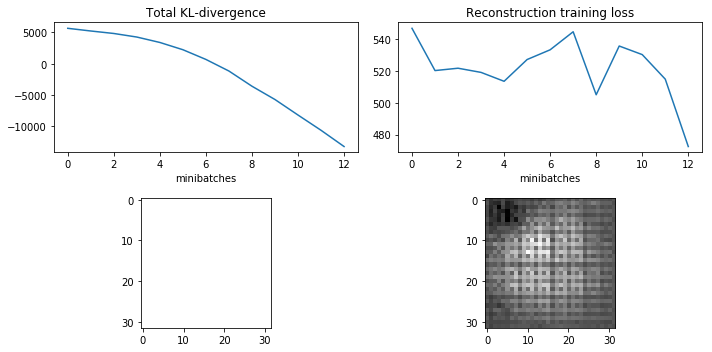

  0%|          | 15/500000 [00:16<151:37:35,  1.09s/it]

iter:14, loss:nan
mu:1,D:1,B:1
z:1,covariance_mats:1,precision_mats:1
recon=nan, kld=nan


RuntimeError: MAGMA gesdd : the updating process of SBDSDC did not converge (error: 18) at /opt/conda/conda-bld/pytorch_1556653114079/work/aten/src/THC/generic/THCTensorMathMagma.cu:307

In [35]:
net.train(plotmode=True)


In [ ]:
del sys.modules['solver']

In [ ]:
print('hi')